# Автоэнкодеры в Keras
# Часть 1: Введение

### Содержание

* ** Часть 1: Введение **
* Часть 2: *Manifold learning* и скрытые (latent) переменные
* Часть 3: Вариационные автоэнкодеры (*VAE*)
* Часть 4: *Conditional VAE*
* Часть 5: *GAN* и tensorflow
* Часть 6: *VAE* + *GAN*


## Автоэнкодеры

***Автоэнкодеры*** - это нейронные сети прямого распространения, которые восстанавливают входной сигнал на выходе. Внутри у них имеется скрытый слой, который представляет собой *код* описывающий модель. *Автоэнкодеры* конструируются таким образом, чтобы не иметь возможность точно скопировать вход на выходе. Обычно их ограничивают в размерности *кода* (он меньше, чем размерность сигнала) или штрафуют за активации в *коде*. Входной сигнал восстанавливается с ошибками из-за потерь при кодировании, но чтобы их минимизировать, сеть вынуждена учиться отбирать наиболее важные признаки.

То есть *автоэнкодеры* состоят из двух частей: энкодера $g$ и декодера $f$. Энкодер переводит входной сигнал в его представление (*код*): $h = g(x)$ , а декодер, как не трудно догадаться, восстанавливает сигнал по его *коду*:  $x=f(h)$.

Автоэнкодер изменяя $f$ и $g$ стремится выучить тождественную функцию $x = f(g(x))$ минимизируя какой-то функционал ошибки

$$ L(x, f(g(x))). $$

При этом семейства функций энкодера $g$ и декодера $f$ как-то ограничены, чтобы автоэнкодер был вынужден отбирать наиболее важные свойства сигнала.

![](figs1/ae_schema.png)

Сама по себе способность автоэнкодеров сжимать данные используется редко, так как обычно они работают хуже, чем вручную написанные алгоритмы для конкретных типов данных вроде звуков или изображений. А также для них критически важно, чтобы данные принадлежали той генеральной совокупности, на которой сеть обучалась. Обучив автоэнкодер на цифрах, его нельзя применять для кодирования чето-то другого (например, человеческих лиц).

Однако автоэнкодеры можно использовать для предобучения, например, когда стоит задача классификации, а размеченных пар слишком мало. Или для понижения размерности в данных для последующей визуализации. Либо когда просто надо научиться различать полезные свойства входного сигнала.

Более того некоторые их развития (о которых тоже будет написано далее), такие как вариационный автоэнкодер (*VAE*), а также его сочетание с состязающимися генеративным сетями (*GAN*) дают очень интересные результаты и находятся сейчас на переднем крае науки о генеративных моделях.

### Keras 

***Keras*** - это очень удобная высокоуровненая библиотека для глубокого обучения, работающая поверх *theano* или *tensorflow*. В ее основе лежат слои, соединяя которые между собой получаем модели. Созданные однажды модели и слои сохраняют в себе свои внутренние параметры, и потому, например, можно обучить слой в одной модели, а использовать его уже в другой, что очень удобно. 

Модели *keras* легко сохранять/загружать, процесс их обучения прост, но в то же время глубоко настраиваемый, они также свободно встраиваются в *tensorflow/theano* код (как операции над тензорами).

В качестве некоторой аналогии можно сказать, что *tensorflow* - аналог *numpy*, а *keras* - аналог *scikit-learn*.

В качестве данных будем использовать датасет рукописных цифр ***MNIST***

Загрузим его:

In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

Using TensorFlow backend.


## Сжимающий автоэнкодер

Для начала создадим наиболее простой (сжимающий, undercomplete) автоэнкодер с *кодом* малой размерности из двух полносвязных слоев: енкодера и декодера.
Так как интенсивность цвета нормировали на единицу, то активацию выходного слоя возьмем сигмоидой.

Создадим отдельные модели для энкодера, декодера и целого автоэнкодера. Для этого создаются экземпляры слоев и применяются один за другим. В конце все объединяется в модели.

In [2]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model

def create_dense_ae():
    # Размерность кодированного представления
    encoding_dim = 49

    # Энкодер
    # Входной плейсхолдер
    input_img = Input(shape=(28, 28, 1)) # 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности
    # Вспомогательный решейпинга слой
    flat_img = Flatten()(input_img)
    # Кодированное полносвязным слоем представление
    encoded = Dense(encoding_dim, activation='relu')(flat_img)
    
    # Декодер
    # Раскодированное другим полносвязным слоем изображение
    input_encoded = Input(shape=(encoding_dim,))
    flat_decoded = Dense(28*28, activation='sigmoid')(input_encoded)
    decoded = Reshape((28, 28, 1))(flat_decoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать как и слои
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

Создадим и скомпилируем модель (под компиляцией в данном случае понимается построение графа вычислений *обратного распространения ошибки*)

In [3]:
encoder, decoder, autoencoder = create_dense_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Взглянем на число параметров

In [4]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 49)                38465     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         39200     
Total params: 77,665.0
Trainable params: 77,665.0
Non-trainable params: 0.0
_________________________________________________________________


~~~
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 49)                38465     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         39200     
=================================================================
Total params: 77,665.0
Trainable params: 77,665.0
Non-trainable params: 0.0
_________________________________________________________________
~~~

Обучим теперь наш автоэнкодер

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s - loss: 0.2563 - val_loss: 0.1693
Epoch 2/50
60000/60000 [==============================] - 3s - loss: 0.1522 - val_loss: 0.1357
Epoch 3/50
60000/60000 [==============================] - 3s - loss: 0.1273 - val_loss: 0.1174
Epoch 4/50
60000/60000 [==============================] - 2s - loss: 0.1125 - val_loss: 0.1055
Epoch 5/50
60000/60000 [==============================] - 2s - loss: 0.1026 - val_loss: 0.0974
Epoch 6/50
60000/60000 [==============================] - 3s - loss: 0.0956 - val_loss: 0.0916
Epoch 7/50
60000/60000 [==============================] - 3s - loss: 0.0905 - val_loss: 0.0874
Epoch 8/50
60000/60000 [==============================] - 3s - loss: 0.0869 - val_loss: 0.0845
Epoch 9/50
60000/60000 [==============================] - 3s - loss: 0.0845 - val_loss: 0.0826
Epoch 10/50
60000/60000 [==============================] - 3s - loss: 0.0829 - val_loss: 0.0814

~~~
Epoch 45/50
60000/60000 [==============================] - 3s - loss: 0.0785 - val_loss: 0.0778
Epoch 46/50
60000/60000 [==============================] - 3s - loss: 0.0785 - val_loss: 0.0777
Epoch 47/50
60000/60000 [==============================] - 2s - loss: 0.0784 - val_loss: 0.0777
Epoch 48/50
60000/60000 [==============================] - 3s - loss: 0.0784 - val_loss: 0.0777
Epoch 49/50
60000/60000 [==============================] - 2s - loss: 0.0784 - val_loss: 0.0777
Epoch 50/50
60000/60000 [==============================] - 3s - loss: 0.0784 - val_loss: 0.0777
~~~

Функция отрисовки цифр

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

Закодируем несколько изображений и, ради интереса, взглянем на пример кода

In [7]:
n = 10

imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)
encoded_imgs[0]

array([  4.28358459,   2.22220135,   8.33176517,  21.19366074,
         6.33620453,   7.53384686,   7.70641899,   2.16347837,
         4.51860476,   5.61786795,   4.16672897,   4.01271629,
         7.06731129,  10.84380913,   6.92695236,   9.21917248,
         7.41956806,   6.44995213,   4.30125046,   6.37940407,
         6.00184822,   5.47228813,   7.12031746,   6.46543312,
         2.48949385,   8.72601891,   6.14625311,   3.28032804,
         3.12649679,   3.80684423,  10.0715971 ,   4.45334291,
        11.9059391 ,   7.46395874,   4.56330204,   3.38781881,
         8.82078362,   4.21308327,   8.96483517,   2.2655549 ,
         8.59859848,   9.07495785,   1.82630551,   4.87585926,
         5.57831669,   8.98233223,   3.94813228,   3.354146  ,   3.60630441], dtype=float32)

~~~
array([  6.64665604,   7.53528595,   3.81508064,   4.66803837,
         1.50886345,   5.41063929,   9.28293324,  10.79530716,
         0.39599913,   4.20529413,   6.53982353,   5.64758158,
         5.25313473,   1.37336707,   9.37590599,   6.00672245,
         4.39552879,   5.39900637,   4.11449528,   7.490417  ,
        10.89267063,   7.74325705,  13.35806847,   3.59005809,
         9.75185394,   2.87570286,   3.64097357,   7.86691713,
         5.93383646,   5.52847338,   3.45317888,   1.88125253,
         7.471385  ,   7.29820824,  10.02830505,  10.5430584 ,
         3.2561543 ,   8.24713707,   2.2687614 ,   6.60069561,
         7.58116722,   4.48140812,   6.13670635,   2.9162209 ,
         8.05503941,  10.78182602,   4.26916027,   5.17175484,   6.18108797], dtype=float32)
~~~

Декодируем эти коды и сравним с оригиналами

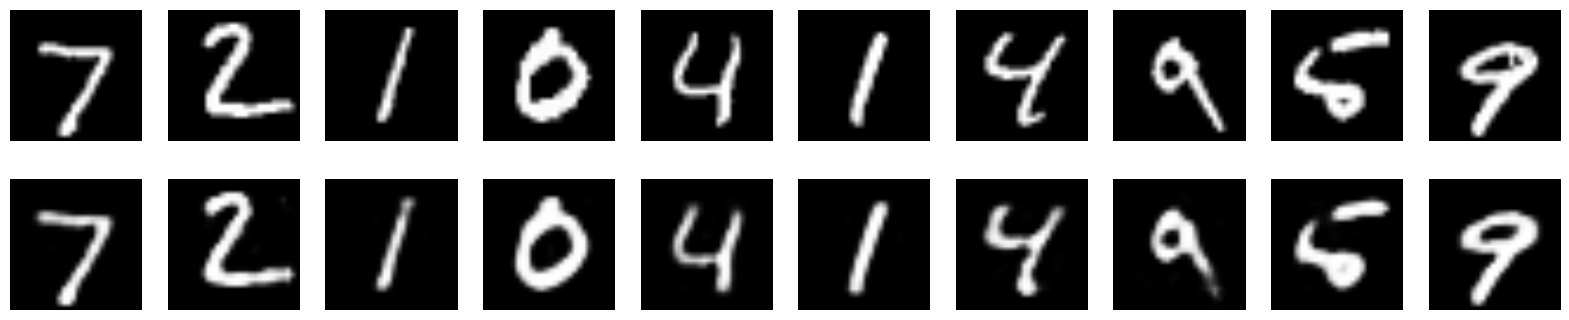

In [8]:
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

![](figs1/ae.png)

## Глубокий автоэнкодер

Никто не мешает нам сделать такой же автоэнкодер, но с большим числом слоев. В таком случае он сможет вычлинять более сложные нелинейные закономерности

In [9]:
def create_deep_dense_ae():
    # Размерность кодированного представления
    encoding_dim = 49

    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*3, activation='relu')(flat_img)
    x = Dense(encoding_dim*2, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='linear')(x)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(encoding_dim*3, activation='relu')(x)
    flat_decoded = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

d_encoder, d_decoder, d_autoencoder = create_deep_dense_ae()
d_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Посмотрим на *summary* нашей модели

In [10]:
d_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 49)                134750    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         135485    
Total params: 270,235.0
Trainable params: 270,235.0
Non-trainable params: 0.0
_________________________________________________________________


~~~
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 49)                134750    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         135485    
=================================================================
Total params: 270,235.0
Trainable params: 270,235.0
Non-trainable params: 0.0
~~~

Число параметров выросло более чем в 3 раза, посмотрим справится ли новая модель лучше

In [11]:
d_autoencoder.fit(x_train, x_train,
                  epochs=100,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s - loss: 0.2203 - val_loss: 0.1433
Epoch 2/100
60000/60000 [==============================] - 3s - loss: 0.1294 - val_loss: 0.1174
Epoch 3/100
60000/60000 [==============================] - 3s - loss: 0.1139 - val_loss: 0.1083
Epoch 4/100
60000/60000 [==============================] - 3s - loss: 0.1063 - val_loss: 0.1024
Epoch 5/100
60000/60000 [==============================] - 3s - loss: 0.1014 - val_loss: 0.0980
Epoch 6/100
60000/60000 [==============================] - 3s - loss: 0.0978 - val_loss: 0.0952
Epoch 7/100
60000/60000 [==============================] - 3s - loss: 0.0951 - val_loss: 0.0935
Epoch 8/100
60000/60000 [==============================] - 3s - loss: 0.0931 - val_loss: 0.0909
Epoch 9/100
60000/60000 [==============================] - 3s - loss: 0.0914 - val_loss: 0.0896
Epoch 10/100
60000/60000 [==============================] - 3s - loss: 0.0899 - val_lo

~~~
Epoch 95/100
60000/60000 [==============================] - 3s - loss: 0.0723 - val_loss: 0.0722
Epoch 96/100
60000/60000 [==============================] - 3s - loss: 0.0722 - val_loss: 0.0724
Epoch 97/100
60000/60000 [==============================] - 3s - loss: 0.0722 - val_loss: 0.0719
Epoch 98/100
60000/60000 [==============================] - 3s - loss: 0.0721 - val_loss: 0.0722
Epoch 99/100
60000/60000 [==============================] - 3s - loss: 0.0721 - val_loss: 0.0720
Epoch 100/100
60000/60000 [==============================] - 3s - loss: 0.0721 - val_loss: 0.0720
~~~

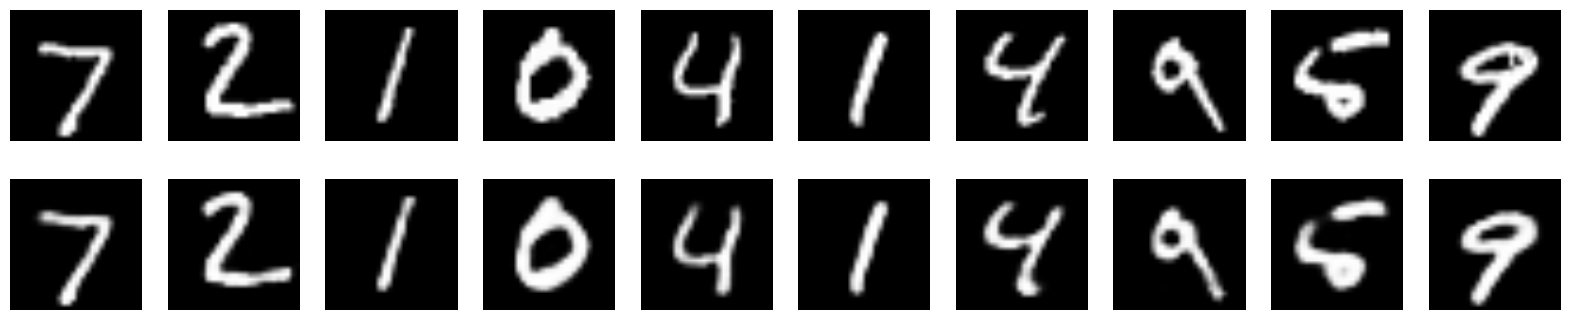

In [12]:
n = 10

imgs = x_test[:n]
encoded_imgs = d_encoder.predict(imgs, batch_size=n)
encoded_imgs[0]

decoded_imgs = d_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

![](figs1/dae.png)
Видим, что лосс насыщается на значительно меньшей величине, да и цифрки слегка более приятные

## Сверточный автоэнкодер

Так как мы работаем с картинками, в данных должна присутствовать некоторая пространственная инвариантность, попробуем этим воспользоваться: построим *сверточный автоэнкодер*

In [4]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

def create_deep_conv_ae():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)

    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное

    input_encoded = Input(shape=(7, 7, 1))
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

c_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 7, 7, 1)           24385     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         24385     
Total params: 48,770
Trainable params: 48,770
Non-trainable params: 0
_________________________________________________________________


~~~
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 7, 7, 1)           24385     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         24385     
=================================================================
Total params: 48,770.0
Trainable params: 48,770.0
Non-trainable params: 0.0
~~~

In [5]:
c_autoencoder.fit(x_train, x_train,
                epochs=64,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/64
 1280/60000 [..............................] - ETA: 1029s - loss: 0.6398

KeyboardInterrupt: 

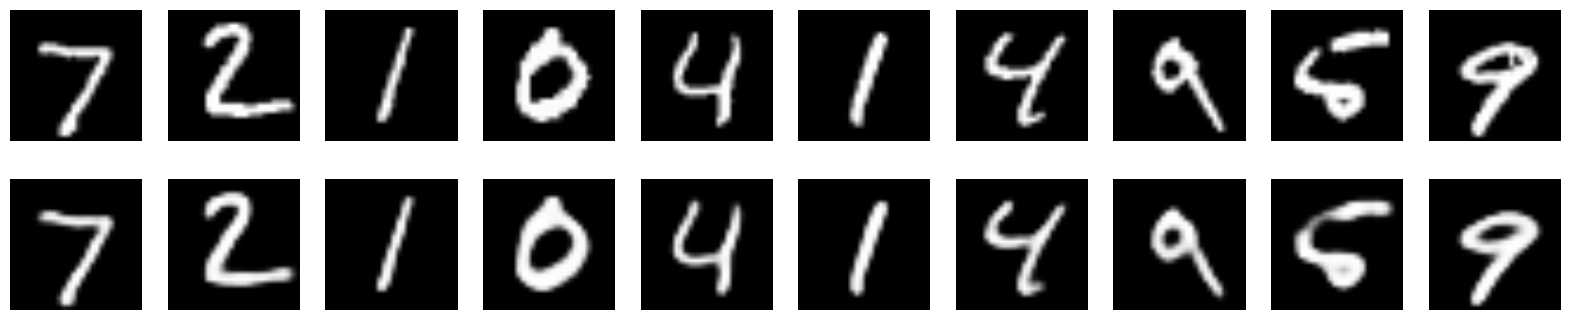

In [15]:
n = 10

imgs = x_test[:n]
encoded_imgs = c_encoder.predict(imgs, batch_size=n)
decoded_imgs = c_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

![](figs1/cae.png)
Не смотря на то, что количество параметров у этой сети намного меньше чем у полносвязных сетей, функция ошибки насыщается на значительно меньшей величине **(НАДО ЕЩЕ РАЗ ПРОГНАТЬ С КАРТОЧКОЙ, ЧТОБЫ ПОКАЗАТЬ)**

## *Denoising* автоэнкодер

Автоэнкодеры можно обучить убирать шум из данных: для этого просто передаем на вход зашумленные данные и сравниваем на выходе с данными без шума:

$$ L(x, f(g(\hat x))), $$
где $\hat x$ - зашумленные данные.

В *Keras* можно оборачивать произвольные операции из нижележащего фреймворка в Lambda слой. Обращаться к операциям из *tensorflow* или *theano* можно через модуль *backend*

Создадим модель которая будет зашумлять входное изображение, а избавлять от шума переобучим какой-либо из уже созданных автоэнкодеров

In [16]:
import keras.backend as K
from keras.layers import Lambda

batch_size = 16

def create_denoising_model(autoencoder):
    def add_noise(x):
        noise_factor = 0.5
        x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 28, 28, 1))
    noised_img = Lambda(add_noise)(input_img)

    noiser = Model(input_img, noised_img, name="noiser")
    denoiser_model = Model(input_img, autoencoder(noiser(input_img)), name="denoiser")
    return noiser, denoiser_model


noiser, denoiser_model = create_denoising_model(autoencoder)
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
denoiser_model.fit(x_train, x_train,
                   epochs=200,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
 6704/60000 [==>...........................] - ETA: 39s - loss: 0.2822

KeyboardInterrupt: 

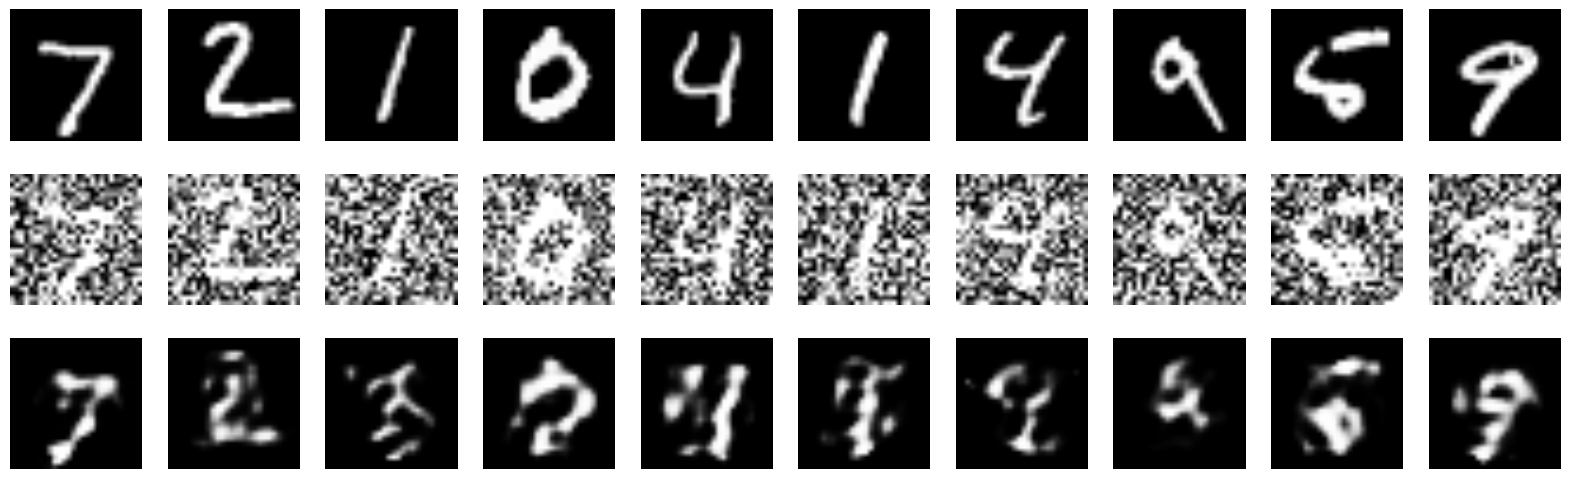

In [18]:
n = 10

imgs = x_test[:batch_size]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
encoded_imgs = encoder.predict(noised_imgs[:n],  batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs[:n], batch_size=n)

plot_digits(imgs[:n], noised_imgs, decoded_imgs)

![](figs1/denoiser.png)
Цифры на зашумленных изображениях с трудом проглядываются, однако *denoising autoencoder* неплохо убрал шум и цифры стали вполне читаемыми

## Разреженный (*Sparse*) автоэнкодер

Разреженный автоэнкодер - это просто автоэнкодер, у которого в функцию потерь добавлен штраф за величины значений в *коде*, то есть автоэнкодер стремится минимизировать такую функцию ошибки:

$$ L(x, f(g(x))) + \Omega(h), $$
где $h = g(x)$ - код,

$\Omega(h)$ - обычный регуляризатор (например L1):
$$\Omega(h) = \lambda * |h|$$

Разреженный автоэнкодер не обязательно сужается к центру. Его *код* может иметь и большую размерность, чем входной сигнал. Обучаясь приближать тождественную функцию $x = f(g(x))$ он учится в *коде* выделять полезные свойства сигнала. Из-за регуляризатора даже расширяющийся к центру разреженный автоэнкодер не может выучить тождественную функцию напрямую.

In [19]:
from keras.regularizers import L1L2

def create_sparse_ae():
    encoding_dim = 16
    lambda_l1 = 0.00001
    
    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*3, activation='relu')(flat_img)
    x = Dense(encoding_dim*2, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='linear', activity_regularizer=L1L2(lambda_l1))(x)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(encoding_dim*3, activation='relu')(x)
    flat_decoded = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

s_encoder, s_decoder, s_autoencoder = create_sparse_ae()
s_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [20]:
s_autoencoder.fit(x_train, x_train,
                epochs=400,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/400
60000/60000 [==============================] - 3s - loss: 0.2907 - val_loss: 0.2183
Epoch 2/400
60000/60000 [==============================] - 3s - loss: 0.1912 - val_loss: 0.1700
Epoch 3/400
60000/60000 [==============================] - 3s - loss: 0.1626 - val_loss: 0.1542
Epoch 4/400
60000/60000 [==============================] - 3s - loss: 0.1499 - val_loss: 0.1444
Epoch 5/400
60000/60000 [==============================] - 3s - loss: 0.1430 - val_loss: 0.1387
Epoch 6/400
60000/60000 [==============================] - 3s - loss: 0.1375 - val_loss: 0.1342
Epoch 7/400
60000/60000 [==============================] - 3s - loss: 0.1334 - val_loss: 0.1298
Epoch 8/400
60000/60000 [==============================] - 3s - loss: 0.1287 - val_loss: 0.1256
Epoch 9/400
60000/60000 [==============================] - 3s - loss: 0.1255 - val_loss: 0.1230
Epoch 10/400
60000/60000 [==============================] - 3s - loss: 0.1234 - val_lo

Взглянем на коды

In [21]:
n = 10

imgs = x_test[:n]
encoded_imgs = s_encoder.predict(imgs, batch_size=n)
encoded_imgs[1]

array([  7.13531828,  -0.61532277,  -5.95510817,  12.0058918 ,
        -1.29253936,  -8.56000137,  -7.48944521,  -0.05415952,
        -2.81205249,  -8.4289856 ,  -0.67815018, -11.19531345,
        -3.4353714 ,   3.18580866,  -0.21041733,   4.13229799], dtype=float32)

~~~
array([  7.13531828,  -0.61532277,  -5.95510817,  12.0058918 ,
        -1.29253936,  -8.56000137,  -7.48944521,  -0.05415952,
        -2.81205249,  -8.4289856 ,  -0.67815018, -11.19531345,
        -3.4353714 ,   3.18580866,  -0.21041733,   4.13229799], dtype=float32)
~~~

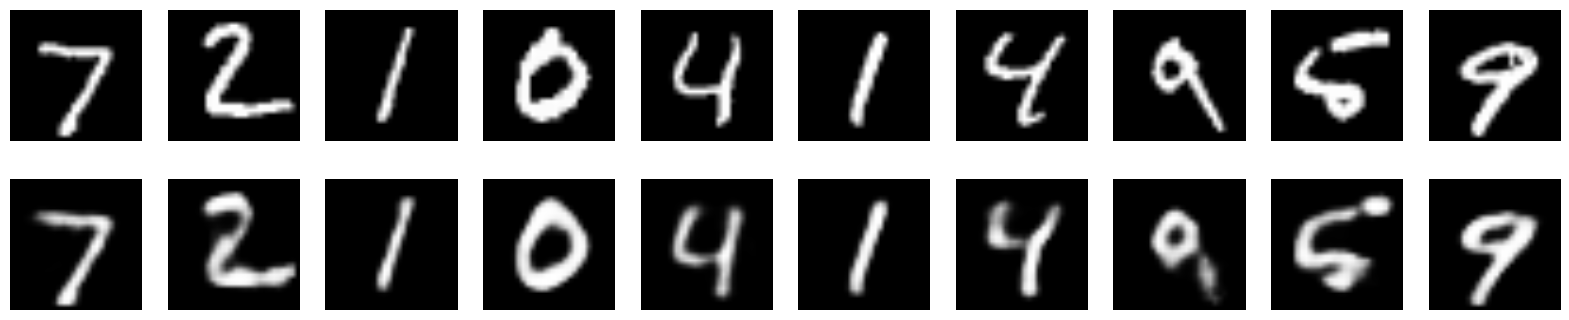

In [22]:
decoded_imgs = s_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

![](figs1/sae.png)
Посмотрим, можно ли как-то интерпретировать размерности в кодах.  
Возьмем среднее из всех кодов, а потом поочереди каждую размерность в среднем коде заменим на максимальное ее значение.

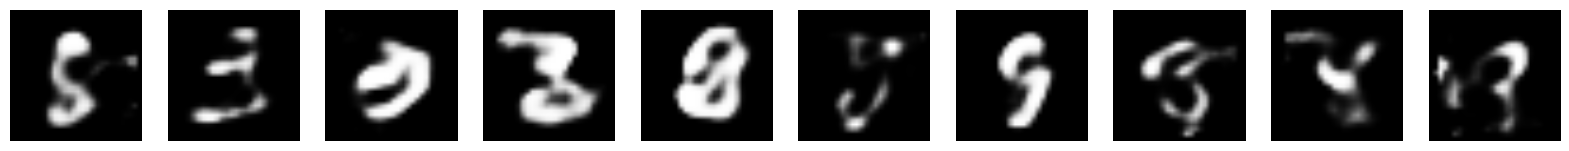

In [23]:
imgs = x_test
encoded_imgs = s_encoder.predict(imgs, batch_size=16)
codes = np.vstack([encoded_imgs.mean(axis=0)]*10)
np.fill_diagonal(codes, encoded_imgs.max(axis=0))

decoded_features = s_decoder.predict(codes, batch_size=16)
plot_digits(decoded_features)

![](figs1/sae_feat.png)
Какие-то черты проглядываются, но ничего толкового тут не видно.
Значения в кодах по одиночке никакого очевидного смысла не несут, лишь хитрое взаимодействие между значениями, происходящее в слоях декодера, позволяет ему по коду восстановить входной сигнал. 

Можно ли из кодов генерировать объекты по собственному желанию?

Для того, чтобы ответить на этот вопрос, следует лучше изучить, что такое коды, и как их можно интепретировать.

## Полезные ссылки и литература

Этот пост основан на собственной интерпретации первой части поста создателя *Keras* *Francois Chollet* про автоэнкодеры в Keras:  
https://blog.keras.io/building-autoencoders-in-keras.html  

А так же главы про автоэнкодеры в *Deep Learning Book*:  
http://www.deeplearningbook.org/contents/autoencoders.html